This version break the rule by using real_possible_answers like the list of possible answers from the first step. Unlike normal hard mode, guess is chosen from allowed guess list and all word in this list could be possible answers, this case use word from all guess list but all word in real_possible_answers list will be included in final answer

In [3]:
import json
from math import *
with open('allowed_guesses.txt','r') as file:
# with open("real_possible_answers.txt","r") as file:
    allowed_guesses=[]
    for i in file:
        allowed_guesses.append(i[:5])
with open("real_possible_answers.txt","r") as file:
        real_possible_answers=[]
        for i in file:
            real_possible_answers.append(i[:5])


In [4]:
def get_feedback(guess:str,answer:str) -> list: 
    """
    get_feeback
    ----------
    guess: Five-letter guess.
    answer: Five-letter correct answer.
    Returns: Feedback contains 05 elements, which can be 0, 1, or 2, denoting a feedback pattern
    """
    # convert string to list
    answer = list(answer)
    guess = list(guess)
    
    #initialize
    feedback = ['']*5
    
    # isolate correctly placed letters
    for i in range(5):
        if guess[i] == answer[i]:
            feedback[i] = 2
            answer[i] = ''
            guess[i] = ''

    for i in range(5):
        if guess[i] == '': continue
        try:
            index=answer.index(guess[i])
            feedback[i] = 1
            answer[index] = ''
            guess[i] = ''
        except:
            feedback[i]=0
    return feedback

get_feedback('speed','crepe')

[0, 1, 2, 1, 0]

In [5]:
def reduce_list(guess:str,feedback:list,possible_answers:list) ->list:
    '''This function return the reduced allowed word list - possible answers list which have real answer
    
    guess: the word we guessed in this step
    feedback: the pattern given by game
    word_list: allowed list in the first step and the reduced list in the next steps
    '''
    return [word for word in possible_answers if get_feedback(guess,word)==feedback]
len(reduce_list('slate',[1,0,1,2,0],allowed_guesses))



74

In [6]:
def convert_ternary(feedback):
    """
    Parameters
    ----------
    Feedback: Contains 05 elements, which can be 0, 1, or 2, denoting a feedback pattern.
    Returns
    -------
    Number: Integer base 10 representation of pattern.
    """
    return sum([feedback[i]*3**(4-i) for i in range(5)])
convert_ternary([1,2,0,0,2])

137

In [29]:
def entropy(guess:str, possible_answers:list):
    '''Function compute the entropy of each word which could be chosen in hard mode \n
    Return value of entropy(bits), dictionary has key= pattern and value= reduced possible answers list \n  
    Detail: It computes expected value of probability distribution of possible patterns, \n 
    based on possible answer(reduced list) or allowed list at initial \n
    pattern=guess + word in possible answers \n
    p= number of specific pattern / total patterns of word_list'''
    Entropy=0
    total = len(possible_answers) 
    PD_patterns = {} #probability distribution of patterns
    for word in possible_answers: 
        feedback = get_feedback(guess,word)
        fb=convert_ternary(feedback)
        # PD_patterns[fb] = PD_patterns.get(fb,[]) +[word] 
        PD_patterns[fb]=PD_patterns.get(fb,0)+1/total
    for prob in PD_patterns.values():
        # Numberofpattern=len(lst)
        # prob=Numberofpattern/total
        # prob=lst
        Entropy+=-(prob)*(log(prob)/log(2))
    # print(PD_patterns)
    return Entropy
entropy('crane',real_possible_answers)



5.741011320165296

In [8]:
def entropy_dict(allowed_guesses,possible_answers):
    '''Function compute entropy of each word in list
    Return the rank of possible answer (result of entropy function) based value of entropy
    It may take less then 10 mins to compute for the first list - first guess'''
    ranker=[]
    for guess in allowed_guesses:
        ranker.append((guess,entropy(guess,possible_answers)))
    ranker.sort(key = lambda t: t[1], reverse = True)
    return ranker


In [14]:
# import json
# with open('firstguesses_hackHM.json','w') as f:
#     json.dump(entropy_dict(allowed_guesses,real_possible_answers),f)
# with open('firstguesses_hackHM.json','r') as f:
#     file=json.load(f)
# print(len(file))


['soare', 5.885202744292758]


In [9]:
def savefile(name:str):
    with open(f'{name}.json','w') as f:
        json.dump(entropy_dict(allowed_guesses,real_possible_answers),f)


In [43]:
def openfile(name):
    with open(f'{name}.json','r') as f:
        file=json.load(f)
    return file
file=openfile('firstguesses_hackHM')
print(len(file))

12953


In [40]:
def solution(answer,inputted=False):
    '''This function return the number of step in this play\n
    answer: The secret word of the game
    input : True is feedback inputted from terminal and vice versa
    '''
    k=0
    guess=file[0]
    word_list=allowed_guesses
    while True:
        k+=1
        # it is real game
        if inputted:
            print(guess)
            feedback=[int(i) for i in str(input())]
        else:
            feedback=get_feedback(guess,answer)
        if feedback==[2]*5:
            break
        #use the solution
        word_list=reduce_list(guess,feedback,word_list)
        if len(word_list)==1:
            guess=word_list[0]
        else:
            # guess=entropy_dict(allowed_guesses,word_list)[0][0]
            guess=entropy_dict(allowed_guesses,word_list)[0][0]
            
    return k
solution('leans')
#33.5s/word



5

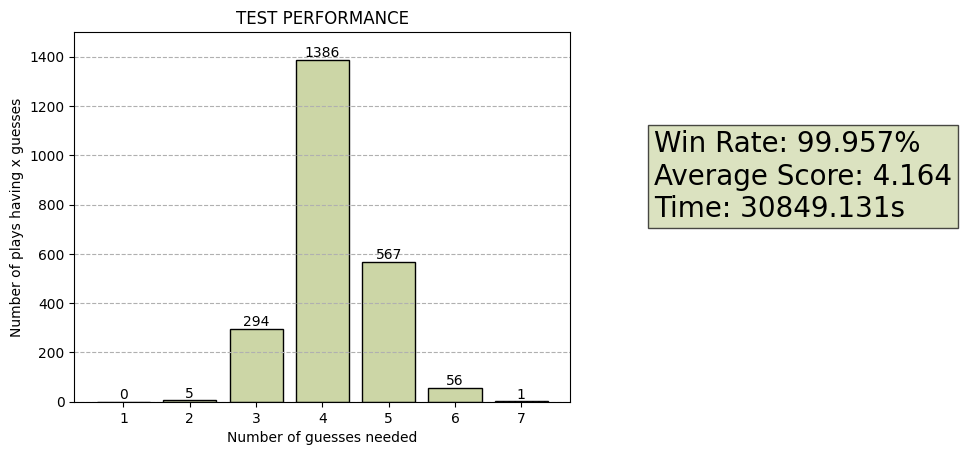

(99.95669120831529, 4.163707232568211)

In [41]:
def TestModel(solution,test_list:list,RANDOM=False) -> tuple:
    '''
    Parameter
    ----------
    solution: The function return the number of step to guess a specific answer \n
    test_list: The list of answers for testing
    RANDOM: False, answer is chosen randomly and True, answer is chosen sequentially from the test_list
    ----------
    Return: The bar chart with x(number of guesses needed) and y (number of plays having x guesses) \n
                  The tupple of winrate and average score'''
    import random
    import time
    t1=time.time()
    #Compute some vital factor: number of plays having x guesses, win rate, average score of 2,3k plays   
    xMax=20 # may be posituve infinity number
    yMax=0
    lst=[0]*xMax
    N=len(test_list)# list contains number of plays having x guesses
    for word in test_list:
        if not RANDOM:
            answer=word
        elif RANDOM:
            answer=random.choice(test_list)
        NumberOfGuessesNeeded=solution(answer) 
        lst[NumberOfGuessesNeeded]=lst[NumberOfGuessesNeeded]+1
    winrate=sum(lst[1:7])/N*100
    average=sum([i*lst[i] for i in range(1,xMax)]) / N

    #VISUALIZATION
    import matplotlib.pyplot as plt
    for i in range(1,xMax):
        if lst[i] >=yMax: # because yMax always in (1,6)
            yMax=lst[i]
        if lst[i]==0 and i>6:
            xMax=i
            break
    yMax=(yMax//100+2)*100
    x=[str(i) for i in range(1,xMax)]
    y=[i for i in lst[1:xMax]]
    plt.ylim(0,yMax)
    plt.grid(axis='y',linestyle='--')
    plt.xlabel('Number of guesses needed')
    plt.ylabel('Number of plays having x guesses')
    plt.title('TEST PERFORMANCE')
    plt.bar(x,y, fc="#CCD6A6", ec="black")
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha="center", va="bottom")
    t2=time.time()
    time=t2-t1
    plt.text(xMax,yMax/2, f'Win Rate: {winrate:.3f}%\nAverage Score: {average:.3f}\nTime: {time:.3f}s', fontsize = 20,
		bbox = dict(facecolor = '#CCD6A6', alpha = 0.7))
    plt.show()
    return winrate,average

TestModel(solution,real_possible_answers)
        
#all choose from real_possible_word
#